In [1]:
import pandas as pd
import networkx as nx

import nltk
from nltk.corpus import gutenberg

import re

# download the gutenberg corpus
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\itsgo\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [2]:
# for visualization
import numpy as np
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5, scores=True):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores=scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
def get_text():
    
    # find Jane Austen texts
    austen_texts = [fileid for fileid in gutenberg.fileids() if 'austen' in fileid]

    # combine the texts into one text variable
    text = ''
    for fileid in austen_texts:
        text += gutenberg.raw(fileid)
        
    return text

In [4]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

# Get and Clean Text
First, I want to get all of the Jane Austen text, and remove all punctuation. I want only words. This will be quick and dirty, not perfect. Perfect will take a lot more time and this is a demonstration.

To do this better, we would scrub all of the book-related context, such as shown at the beginning of text.

I don't want to lowercase everything, because then names will be lowercased. This is not a use-case to lowercase everything.

In [5]:
text = get_text()
print(text[0:500])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


In [6]:
# Replace newlines (\n) and carriage returns (\r) with spaces
text = re.sub(r'[\n\r]+', ' ', text)

# Remove all non-word characters except spaces, apostrophes and dashes
text = re.sub(r'[^\w\s\'-]', ' ', text)

# # Replace multiple spaces with a single space
# text = re.sub(r'\s+', ' ', text)

text = text.replace('--', ' ')
text = text.strip()

# Output the cleaned text
print(text[0:500])

Emma by Jane Austen 1816  VOLUME I CHAPTER I Emma Woodhouse  handsome  clever  and rich  with a comfortable home and happy disposition  seemed to unite some of the best blessings of existence  and had lived nearly twenty-one years in the world with very little to distress or vex her  She was the youngest of the two daughters of a most affectionate  indulgent father  and had  in consequence of her sister's marriage  been mistress of his house from a very early period   Her mother had died too lon


# Create Word Graph

Next, we split the text using the spaces between words to split. Then, we map the use of words, from one word to the next. We use this mapping as our edgelist.

In [7]:
def build_word_edgelist(words):

    i = 0

    edgelist = []

    # we use the i iterator rather than a 'for word in words' to more easily use the next word
    while i < len(words):

        current_word = words[i]

        if i < len(words)-1:
            next_word = words[i+1]
        else:
            next_word = ''

        edge = (current_word, next_word)

        edgelist.append(edge)

        i += 1
        
    return edgelist

In [8]:
words = text.split()
words[0:10]

['Emma', 'by', 'Jane', 'Austen', '1816', 'VOLUME', 'I', 'CHAPTER', 'I', 'Emma']

In [9]:
edgelist = build_word_edgelist(words)

edgelist[0:3]

[('Emma', 'by'), ('by', 'Jane'), ('Jane', 'Austen')]

In [10]:
G = nx.from_edgelist(edgelist)
G.remove_edges_from(nx.selfloop_edges(G))

In [11]:
print(G), G

Graph with 12086 nodes and 125699 edges


(None, <networkx.classes.graph.Graph at 0x1e120d08f10>)

# Explore the Core

On day 34, I describe investigating k-corona as peeling an onion. https://100daysofnetworks.substack.com/p/day-34-of-100daysofnetworks

k-corona is one way of peeling the onion, but another simpler way for us to get to our goal is to just use degree counts.

It is always useful to start by exploring the core. These are the most densely connected words, the most used words.

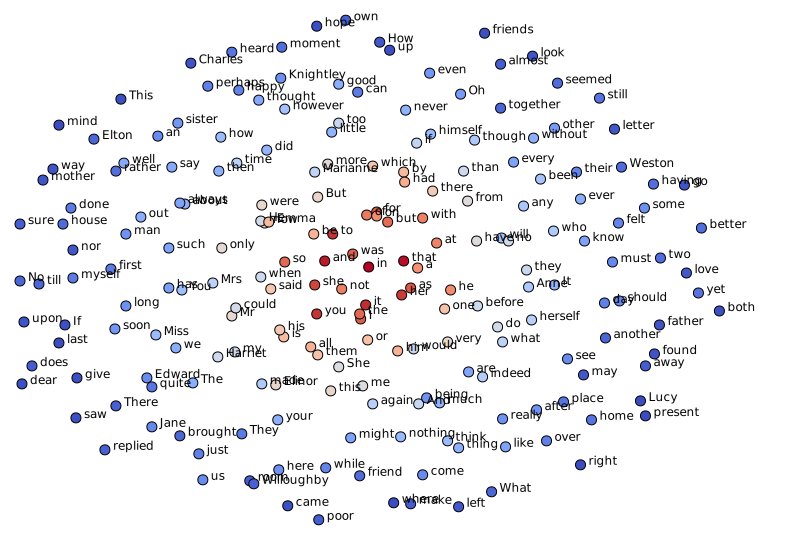

In [12]:
nodes = nx.k_core(G, 76).nodes

G_core = G.subgraph(nodes)

draw_graph(G_core, edge_width=0.01, node_size=5, show_names=True, font_size=12)

In [13]:
degree_df = pd.DataFrame(G.degree)
degree_df.columns = ['node', 'degrees']
degree_df.set_index('node', inplace=True)
degree_df.head()

,degrees
node,
Emma,547
by,1109
Jane,215
Austen,4
1816,2


In [14]:
degree_df['degrees'].max()

4424

In [15]:
degree_df[degree_df['degrees'] == 4424].index.values[0]

'and'

In [16]:
def get_degree_vocabulary(G, degree_df, degrees):
    
    vocab = sorted(degree_df[degree_df['degrees']==degrees].index.values)
    vocab = [v for v in vocab if v != '']
    
    return vocab

In [17]:
get_degree_vocabulary(G, degree_df, 1)

['Epicurism',
 'Louise',
 'Ma',
 'Sixty',
 'Theodore',
 '_try_',
 'acknowledgements',
 'adviser',
 'brotherliness',
 'brutal',
 'callers',
 'caprices',
 'carpentered',
 'cellery',
 'clean',
 'cling',
 'conform',
 'convivial',
 'discreetly',
 'disposing',
 'educate',
 'falsehoods',
 'fir',
 'flowers',
 'fretted',
 'glued',
 'hardy',
 'indelicate',
 'inhumanity',
 'ladylike',
 'languish',
 'maturity',
 'milkmen',
 'mulberry-tree',
 'necessitous',
 'olives',
 'orange',
 'orderly',
 'overseers',
 'pallid',
 'prescience',
 'prosing',
 'proudly',
 'reliance',
 'religion',
 'repossessed',
 'resort',
 'rides',
 'rubbed',
 'simpered',
 'sneers',
 'stiles',
 'swollen',
 'thistles',
 'unawares',
 'unbending',
 'unfastidious',
 'ungallant',
 'unmodernized',
 'unwise',
 'varnished',
 'verdure']

# Build Vocabulary Lists

In [18]:
for degrees in range(1, 21):
    
    print('degrees: {}'.format(degrees))
    print()
    vocab = get_degree_vocabulary(G, degree_df, degrees)
    vocab = ', '.join(vocab)
    print(vocab)
    print()
    print('---------------------------')
    print()

degrees: 1

Epicurism, Louise, Ma, Sixty, Theodore, _try_, acknowledgements, adviser, brotherliness, brutal, callers, caprices, carpentered, cellery, clean, cling, conform, convivial, discreetly, disposing, educate, falsehoods, fir, flowers, fretted, glued, hardy, indelicate, inhumanity, ladylike, languish, maturity, milkmen, mulberry-tree, necessitous, olives, orange, orderly, overseers, pallid, prescience, prosing, proudly, reliance, religion, repossessed, resort, rides, rubbed, simpered, sneers, stiles, swollen, thistles, unawares, unbending, unfastidious, ungallant, unmodernized, unwise, varnished, verdure

---------------------------

degrees: 2

'But, 'For, 'It, 'La, 'So, 'THERE, 'The, 'Twill, 'consider, 'do, 'em, 'is, 'it, 'making, 'my, 'prenticed, 's, 'setting, 'squire, 'that, 'the, 'they, 'twould, 'you, -, -5, -and, 000, 1760, 1784, 1785, 1787, 1789, 1791, 1800, 1803, 1806, 1810, 1811, 1814, 1816, 1818, 1st, 200, 23rd, 24th, 25, 26, 26th, 27, 28, 29, 29th, 30, 31, 32, 33, 34, 

In [19]:
degrees = 4424

get_degree_vocabulary(G, degree_df, degrees)

['and']

# Get Definitions

From here, you can look into the different layers and choose words alphabetically. In my case, I chose to drop everything not lowercase, and limit to letters that start with A. You can/should comment those lines out and explore.

In [20]:
degrees = 2

vocab = get_degree_vocabulary(G, degree_df, degrees)
vocab = [w for w in vocab if w.islower()]
vocab = [w for w in vocab if w.startswith('a')]

words = ', '.join(vocab)
print(words)

a-day, a-shooting, abandoned, abatement, abbreviation, abdication, ablest, abolition, abominably, abominate, abominates, abounded, abridge, abridgement, absences, absented, absorbing, abstained, abstracted, abstruse, absurdities, abundant, abuses, acacia, acceded, accelerate, acceptably, accepts, accessions, accidently, accompaniment, accord, accountable, accounting, accumulation, accumulations, accustom, accustomed, aches, achievement, acquaintances, acquire, acquitting, acres, acrostic, actuated, acutely, adherence, adhering, adjusting, administered, administering, admirers, admits, adoption, adored, adoring, advancement, adventuring, adventurous, adversary's, adverse, advertise, advertised, advertising, affects, affirm, affix, afflict, afflicting, afflictions, affluent, affronts, after-days, afterward, againsts, agent, aggrandise, aggrandizement, aggression, aghast, agitating, agriculture, ah, ahead, aids, ailed, aim, aimable, akin, al-fresco, alienable, alienated, alienations, alig